In [ ]:
# linear_eval.py

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

###############################################################################
# 1. IMPORT THE EXACT ENCODER USED IN TRAINING
###############################################################################

from contrastive_pretrain_resnet18 import get_encoder, SimCLR


###############################################################################
# 2. LINEAR CLASSIFIER FOR EVALUATION
###############################################################################

class LinearClassifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
###############################################################################
# 3. BASIC TRANSFORM (NO AUGMENTATION)
###############################################################################

def get_basic_transform():
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std  = (0.2470, 0.2435, 0.2616)
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar_mean, cifar_std),
    ])

# for visualization (Grad-CAM overlay)
def unnormalize(img_tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
    return img_tensor * std + mean

In [ ]:
###############################################################################
# 4. EMBEDDING EXTRACTION (FROZEN ENCODER)
###############################################################################

def extract_embeddings(encoder, dataloader, device):
    encoder.eval()
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            h = encoder(imgs)                  # (B, C, 1, 1)
            h = torch.flatten(h, 1)            # (B, C)
            all_embs.append(h.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_embs), torch.cat(all_labels)

In [ ]:
###############################################################################
# 5. TRAIN LINEAR CLASSIFIER
###############################################################################

def train_classifier(
    X_train, y_train, X_val, y_val, in_dim, device,
    epochs=1000, lr=1e-3
):
    clf = LinearClassifier(in_dim=in_dim).to(device)
    opt = torch.optim.AdamW(clf.parameters(), lr=lr, weight_decay=1e-4)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val   = X_val.to(device)
    y_val   = y_val.to(device)

    # --------------------------
    # STORE METRICS PER EPOCH
    # --------------------------
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        # --------------------------
        # TRAIN STEP
        # --------------------------
        clf.train()
        logits = clf(X_train)
        train_loss = F.cross_entropy(logits, y_train)

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        train_preds = logits.argmax(1)
        train_acc = accuracy_score(y_train.cpu(), train_preds.cpu())

        # --------------------------
        # VALIDATION STEP
        # --------------------------
        clf.eval()
        with torch.no_grad():
            val_logits = clf(X_val)
            val_loss = F.cross_entropy(val_logits, y_val)
            val_preds = val_logits.argmax(1)
            val_acc = accuracy_score(y_val.cpu(), val_preds.cpu())

        # --------------------------
        # STORE HISTORY
        # --------------------------
        history["train_loss"].append(train_loss.item())
        history["val_loss"].append(val_loss.item())
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if epoch % 20 == 0 or epoch == 1:
            print(f"[Epoch {epoch:03d}] "
                  f"TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
                  f"TrainAcc={train_acc:.4f} ValAcc={val_acc:.4f}")

    return clf, history

In [ ]:
###############################################################################
# 6. FINAL EVALUATION
###############################################################################

def evaluate_classifier(clf, X_test, y_test, device):
    clf.eval()
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        logits = clf(X_test)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)

    y_true = y_test.cpu()
    y_pred = preds.cpu()
    y_prob = probs.cpu()

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    try:
        auc = roc_auc_score(
            y_true, y_prob, multi_class="ovr", average="macro"
        )
    except ValueError:
        auc = float("nan")

    print("\n=== DOWNSTREAM METRICS ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {p:.4f}")
    print(f"Recall   : {r:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC-OVR  : {auc:.4f}")

    return acc, p, r, f1, auc

In [ ]:
###############################################################################
# 7. t-SNE / PCA STYLE EMBEDDING VISUALIZATION
###############################################################################

def visualize_embeddings(x, y, out_path="tsne_embeddings.png", show=True):
    x = x.numpy()
    y = y.numpy()

    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    z = tsne.fit_transform(x)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=4)
    plt.colorbar(sc, ticks=range(10))
    plt.title("t-SNE of Frozen Encoder Embeddings")

    # Save the figure
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)

    if show:
        plt.show()

    plt.close()

    print(f"[t-SNE] Saved embedding visualization to {out_path}")

In [ ]:
###############################################################################
# 8. Grad-CAM on encoder + linear head
###############################################################################

class EncoderWithHead(nn.Module):
    """
    Convenience wrapper: encoder (frozen) + linear classifier.
    Used only for Grad-CAM; we don't train this.
    """
    def __init__(self, encoder, clf):
        super().__init__()
        self.encoder = encoder
        self.clf = clf

    def forward(self, x):
        h = self.encoder(x)          # (B, C, 1, 1) because of global avg pool
        h_flat = torch.flatten(h, 1)
        logits = self.clf(h_flat)
        return logits


def gradcam_for_examples(encoder, clf, test_ds, device, indices=None, out_dir="gradcam_viz"):
    """
    Compute Grad-CAM heatmaps for a few test images.

    Note: because encoder ends with global average pool to 1x1, the last
    conv feature maps are almost spatially collapsed. We therefore hook
    the layer *before* the final AdaptiveAvgPool2d: encoder[-2].
    """
    os.makedirs(out_dir, exist_ok=True)

    model = EncoderWithHead(encoder, clf).to(device)
    model.eval()

    # pick some example indices if not provided
    if indices is None:
        indices = [0, 1, 2, 3, 4]

    # grab the target conv layer (before avgpool)
    # encoder is Sequential([... layer4, avgpool])
    target_layer = encoder[-2]

    for idx in indices:
        img, label = test_ds[idx]
        img_in = img.unsqueeze(0).to(device)

        activations = []
        gradients = []

        def fwd_hook(module, inp, out):
            activations.append(out)

        def bwd_hook(module, grad_in, grad_out):
            gradients.append(grad_out[0])

        h1 = target_layer.register_forward_hook(fwd_hook)
        h2 = target_layer.register_backward_hook(bwd_hook)

        img_in.requires_grad_(True)
        logits = model(img_in)
        pred_class = logits.argmax(dim=1).item()

        score = logits[0, pred_class]
        model.zero_grad()
        score.backward()

        h1.remove()
        h2.remove()

        act = activations[0].detach()      # (1, C, H, W)
        grad = gradients[0].detach()       # (1, C, H, W)

        # Channel-wise weights
        weights = grad.mean(dim=(2, 3), keepdim=True)   # (1, C, 1, 1)
        cam = (weights * act).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(32, 32), mode="bilinear", align_corners=False)
        cam = cam[0, 0]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        cam_np = cam.cpu().numpy()

        # prepare original image
        img_unnorm = unnormalize(img).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

        # overlay heatmap
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(img_unnorm)
        plt.axis("off")
        plt.title(f"Label: {label}")

        plt.subplot(1, 2, 2)
        plt.imshow(img_unnorm)
        plt.imshow(cam_np, cmap="jet", alpha=0.5)
        plt.axis("off")
        plt.title(f"Grad-CAM (pred {pred_class})")

        out_path = os.path.join(out_dir, f"gradcam_idx{idx}_label{label}_pred{pred_class}.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()
        print(f"[Grad-CAM] Saved {out_path}")

In [ ]:
###############################################################################
# 9. plotting curves
###############################################################################
def plot_learning_curves(history, out_path="linear_eval_curves.png"):
    plt.figure(figsize=(12,5))

    # Loss subplot
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.title("Loss Curves")
    plt.legend()

    # Accuracy subplot
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"[Plot] Saved learning curves to {out_path}")

Loading encoder from checkpoint: simclr_resnet18_multicrop.pt


/tmp/ipykernel_3921644/1242258033.py:360: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


Files already downloaded and verified
Files already downloaded and verified
Extracting embeddings...
Train embeddings: torch.Size([50000, 512])
Test  embeddings: torch.Size([10000, 512])
[Epoch 001] TrainLoss=2.3082 ValLoss=2.2755 TrainAcc=0.0846 ValAcc=0.2418
[Epoch 020] TrainLoss=1.4448 ValLoss=1.3830 TrainAcc=0.8078 ValAcc=0.8360
[Epoch 040] TrainLoss=0.6702 ValLoss=0.6214 TrainAcc=0.8394 ValAcc=0.8620
[Epoch 060] TrainLoss=0.4397 ValLoss=0.4054 TrainAcc=0.8708 ValAcc=0.8858
[Epoch 080] TrainLoss=0.3628 ValLoss=0.3367 TrainAcc=0.8859 ValAcc=0.8996
[Epoch 100] TrainLoss=0.3267 ValLoss=0.3057 TrainAcc=0.8936 ValAcc=0.9060
[Epoch 120] TrainLoss=0.3030 ValLoss=0.2878 TrainAcc=0.8998 ValAcc=0.9082
[Epoch 140] TrainLoss=0.2887 ValLoss=0.2761 TrainAcc=0.9040 ValAcc=0.9112
[Epoch 160] TrainLoss=0.2768 ValLoss=0.2681 TrainAcc=0.9070 ValAcc=0.9114
[Epoch 180] TrainLoss=0.2679 ValLoss=0.2624 TrainAcc=0.9096 ValAcc=0.9140
[Epoch 200] TrainLoss=0.2597 ValLoss=0.2582 TrainAcc=0.9130 ValAcc=0.9154

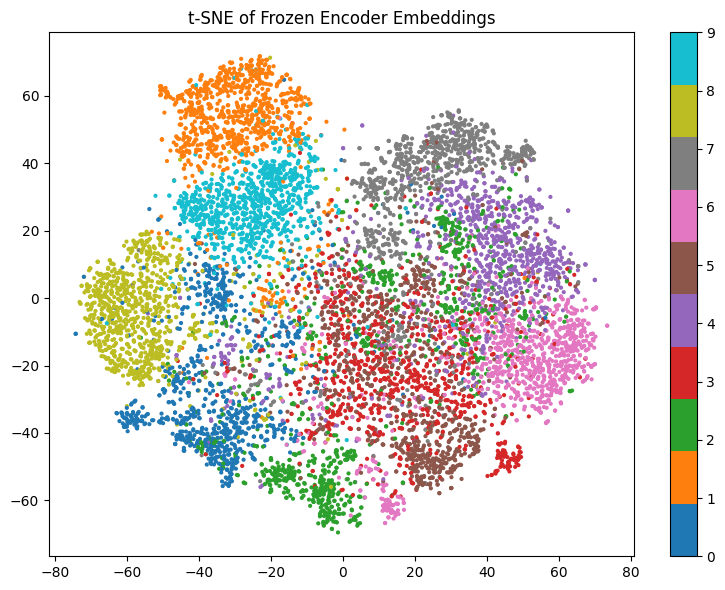

[t-SNE] Saved embedding visualization to tsne_test_embeddings.png


/gpfs/home/ama25d/.conda/envs/polyclip_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[Grad-CAM] Saved gradcam_viz/gradcam_idx0_label3_pred3.png
[Grad-CAM] Saved gradcam_viz/gradcam_idx100_label4_pred4.png
[Grad-CAM] Saved gradcam_viz/gradcam_idx500_label4_pred4.png
[Grad-CAM] Saved gradcam_viz/gradcam_idx1000_label5_pred5.png
[Grad-CAM] Saved gradcam_viz/gradcam_idx1500_label1_pred1.png


In [ ]:
###############################################################################
# 10. MAIN FLOW
###############################################################################

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ckpt_path = "simclr_resnet18_multicrop.pt"

    print("Loading encoder from checkpoint:", ckpt_path)

    # 1) Load encoder arch + pre-trained weights
    encoder, out_dim = get_encoder()
    model = SimCLR()                                  # same arch as training
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    encoder.load_state_dict(model.encoder.state_dict())
    encoder.to(device)

    # freeze encoder
    for p in encoder.parameters():
        p.requires_grad = False

    # 2) CIFAR-10 data
    transform = get_basic_transform()
    train_ds = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    test_ds  = datasets.CIFAR10(root="./data", train=False,  transform=transform, download=True)

    train_loader = DataLoader(train_ds, batch_size=256, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=4)

    # 3) Extract embeddings
    print("Extracting embeddings...")
    X_train, y_train = extract_embeddings(encoder, train_loader, device)
    X_test,  y_test  = extract_embeddings(encoder, test_loader, device)
    print("Train embeddings:", X_train.shape)
    print("Test  embeddings:", X_test.shape)

    # 4) Train/val split
    n = len(X_train)
    n_val = int(0.1 * n)
    X_val, y_val = X_train[:n_val], y_train[:n_val]
    X_tr,  y_tr  = X_train[n_val:], y_train[n_val:]

    # 5) Train linear classifier
    clf, history = train_classifier(
        X_tr, y_tr, X_val, y_val,
        in_dim=X_train.size(1),
        device=device,
        epochs=1000,
        lr=1e-3
    )
    
    plot_learning_curves(history)


    # 6) Evaluate
    evaluate_classifier(clf, X_test, y_test, device)

    # 7) t-SNE visualization of embeddings
    visualize_embeddings(X_test, y_test, out_path="tsne_test_embeddings.png")
    # 8) Grad-CAM on a few test images
    gradcam_for_examples(encoder, clf, test_ds, device, indices=[0, 100, 500, 1000, 1500])


if __name__ == "__main__":
    main()